In [1]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
def visualize_signal(dataframe, source_no=1, sample_index=0):
    sampled_points = 3400
    x_axis = list(range(sampled_points))    
    sample_1 = dataframe.iloc[sample_index].tolist()

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'x_axis': x_axis,
        'y_axis': sample_1
    })
    # Create a line chart
    fig= px.line(df, x='x_axis', y='y_axis', title=f'Source {source_no} Sample {sample_index}')
    # Show the plot
    fig.show()

In [7]:
source_1_file = Path("excel_files\source_1.xlsx")
source_2_file = Path("excel_files\source_2.xlsx")

source_1_df = pd.read_excel(source_1_file, header=None)
source_2_df = pd.read_excel(source_2_file, header=None)

print("Here is data\n", source_1_df)

Here is data
     0     1     2     3     4     5         6         7         8     \
0      2     4    99  5795    23  3400  0.000384  0.000640  0.001408   
1      2     4    96  5532    23  3400 -0.003712 -0.003968 -0.004608   
2      2     4    96  5512    23  3400 -0.000640 -0.000512 -0.000768   
3      2     4    64  1843    23  3400 -0.001152 -0.000896 -0.000384   
4      2     4    55   883    23  3400 -0.002176 -0.001920 -0.001024   
5      2     4    51   400    23  3400  0.016895  0.011903  0.006016   
6      2     4    69  2464    23  3400  0.000768  0.001152  0.001792   
7      2     4    77  3305    23  3400  0.014463  0.011519  0.008319   
8      2     4    51   400    23  3400 -0.000256  0.000256  0.000384   
9      2     4    53   606    23  3400  0.000128 -0.000384 -0.001408   
10     2     4    62  1579    23  3400 -0.002176 -0.001664 -0.001408   
11     2     4    54   699    23  3400  0.000256  0.000768  0.000896   
12     2     4    64  1826    23  3400  0.001664  

In [8]:
column_names = [f'DP-{i}' for i in range(1, 3401)]

source_1_df = source_1_df.drop(source_1_df.columns[:6], axis=1)
source_1_df.columns = column_names
source_1_df['source'] = 0 # 0 for source 1

source_2_df = source_2_df.drop(source_2_df.columns[:6], axis=1)
source_2_df.columns = column_names
source_2_df['source'] = 1 # 1 for source 2

dataframe = pd.concat([source_1_df, source_2_df], axis=0)
dataframe = dataframe.reset_index(drop=True)
dataframe.to_excel('dataframe.xlsx', index=False)

In [9]:
# Build the CNN model
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(3400, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3396, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1698, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1694, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 847, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 843, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 421, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,795,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,009,345 (53.44 MB)

 Trainable params: 14,009,345 (53.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.6268 - loss: 0.6860 - val_accuracy: 0.4286 - val_loss: 0.6721
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7494 - loss: 0.6492 - val_accuracy: 0.6429 - val_loss: 0.6409
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7211 - loss: 0.6003 - val_accuracy: 0.7143 - val_loss: 0.5942
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.8378 - loss: 0.5341 - val_accuracy: 0.7857 - val_loss: 0.5234
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8658 - loss: 0.4439 - val_accuracy: 0.7857 - val_loss: 0.4477
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9411 - loss: 0.3627 - val_accuracy: 0.8571 - val_loss: 0.3416
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9485 - loss: 0.2796 - val_accuracy: 0.9286 - val_loss: 0.2326
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.9039 - loss: 0.2807 - val_accuracy: 1.0000 - val_loss:

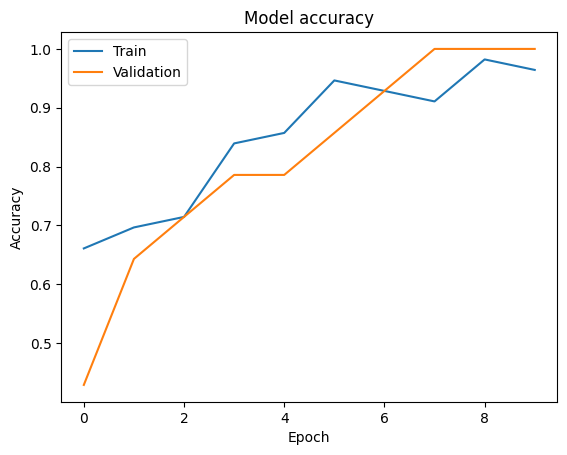

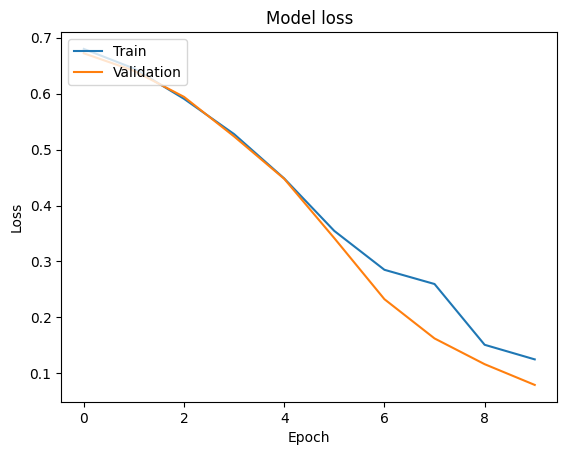

In [10]:
Y = dataframe['source'].to_numpy()
X = dataframe.drop(columns=['source']).to_numpy()
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Reshape the data for the CNN
X_train = X_train.reshape(X_train.shape[0], 3400, 1)
X_test = X_test.reshape(X_test.shape[0], 3400, 1)

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
# Save the model to a file
model.save('source_classification_using_cnn.h5')

In [12]:
# Testing on Excel File

test_file = Path(r"excel_files\test_file.xlsx")
test_df = pd.read_excel(test_file, header=None)
total_rows = test_df.shape[0]
total_columns = test_df.shape[1]
signal_columns = 3400

if total_columns > signal_columns:
    columns_to_drop = total_columns - signal_columns 
    test_df = test_df.drop(test_df.columns[:columns_to_drop], axis=1)
    print(f"Dropping {columns_to_drop} to retrive only signal data.")
elif total_columns == signal_columns:
    print("Signal data provided in excel file, no need to remove any columns.")
else:
    print("Incorrect signal data provided. please provide signal having 3400 sampled points.")


for counter in range(total_rows):
    sample = test_df.iloc[counter].to_numpy()
    # Reshape the sample to match the input shape of the model
    sample_reshaped = sample.reshape(1, 3400, 1)
    # Predict the class (returns a probability)
    prediction = model.predict(sample_reshaped)
    if prediction > 0.5:
        source = 1
    else:
        source = 0
    print(f'Predicted Source {source}')

Dropping 6 to retrive only signal data.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted Source 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Source 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Source 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Source 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Source 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Source 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Source 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Source 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Source 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Source 1


In [11]:
# Testing on Excel File

test_file = Path(r"D:\Study\CI\ComputationalIntelligence\excel_files\test_file.xlsx")
test_df = pd.read_excel(test_file, header=None)
total_rows = test_df.shape[0]
total_columns = test_df.shape[1]
signal_columns = 3400

if total_columns > signal_columns:
    columns_to_drop = total_columns - signal_columns 
    test_df = test_df.drop(test_df.columns[:columns_to_drop], axis=1)
    print(f"Dropping {columns_to_drop} to retrive only signal data.")
elif total_columns == signal_columns:
    print("Signal data provided in excel file, no need to remove any columns.")
else:
    print("Incorrect signal data provided. please provide signal having 3400 sampled points.")


for counter in range(total_rows):
    sample = test_df.iloc[counter].to_numpy()
    # Reshape the sample to match the input shape of the model
    sample_reshaped = sample.reshape(1, 3400, 1)
    # Predict the class (returns a probability)
    prediction = model.predict(sample_reshaped)
    if prediction > 0.5:
        source = 1
    else:
        source = 0
    print(f'Predicted Source {source}')

Dropping 6 to retrive only signal data.
1/1 [==============================] - 0s 35ms/step
Predicted Source 0
1/1 [==============================] - 0s 36ms/step
Predicted Source 1
1/1 [==============================] - 0s 31ms/step
Predicted Source 0
1/1 [==============================] - 0s 33ms/step
Predicted Source 1
1/1 [==============================] - 0s 33ms/step
Predicted Source 0
1/1 [==============================] - 0s 31ms/step
Predicted Source 1
1/1 [==============================] - 0s 32ms/step
Predicted Source 0
1/1 [==============================] - 0s 35ms/step
Predicted Source 1
1/1 [==============================] - 0s 44ms/step
Predicted Source 0
1/1 [==============================] - 0s 38ms/step
Predicted Source 1
